## 1. Setup and Environment Check

First, let's install and import the necessary libraries and verify our computing environment. We will ensure we have PyTorch (for model training), Hugging Face Transformers (for the DistilBERT model and tokenizer), and the Hugging Face Datasets library (to load the IMDB dataset). We also check the GPU availability and software versions:

In [4]:
!pip install -q transformers datasets

import torch, platform
try:
    import transformers
except ImportError:
    print("Installing transformers...")
    import transformers

# Print environment information
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU device: {gpu_name}")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("GPU device: None (using CPU)")


PyTorch version: 2.8.0+cu126
Transformers version: 4.57.1
GPU device: NVIDIA A100-SXM4-40GB
CUDA version: 12.6


In [5]:
# Set random seeds for reproducibility
import torch
import numpy as np
import random

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

print(f"Random seed set to: {seed}")


Random seed set to: 42


# C1: Fine-tuning DistilBERT on IMDB

Task: Fine-tune a small language model (DistilBERT) for binary sentiment classification on the IMDB movie reviews dataset. We will train for 5 epochs with batch size 32, maximum sequence length 256, and learning rate 1e-4. We use the DistilBertForSequenceClassification model (with a binary output) and its associated tokenizer. The tokenizer will perform text encoding with truncation to 256 tokens, and we implement dynamic padding in a custom collate_fn so that each batch is padded only to the length of the longest sequence in that batch.

Steps:

- Load the IMDB dataset via Hugging Face Datasets. This gives us a training set and test set of reviews with labels.

- Initialize the DistilBERT tokenizer and model (pretrained weights).

- Pre-tokenize the dataset with truncation (but no padding yet).

- Define a collate_fn that pads a batch of encoded sequences to the batch's max length.

- Create PyTorch DataLoader for training and testing, using our collate function for dynamic padding. We set num_workers=2 for data loading threads as a default.

- Fine-tune the model for 5 epochs. For each epoch, we track the training loss and accuracy, and also evaluate the model on the test set to get test accuracy.

- Log/print the metrics per epoch, and after training, plot the training loss and accuracy over epochs. Finally, we will present a table of the metrics.

In [7]:
from datasets import load_dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import torch
from torch.utils.data import DataLoader
import torch.optim as optim

# Silence Hugging Face tokenizer warnings
import warnings
warnings.filterwarnings("ignore", message=".*DistilBertTokenizerFast.*")

# Load the IMDB dataset
dataset = load_dataset("imdb")
train_ds = dataset["train"]
test_ds = dataset["test"]

# Initialize the DistilBERT tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Tokenize the datasets (with truncation to max length 256, but no padding yet)
def tokenize_batch(batch):
    return tokenizer(batch["text"], truncation=True, max_length=256)
train_ds = train_ds.map(tokenize_batch, batched=True, remove_columns=["text"])
test_ds = test_ds.map(tokenize_batch, batched=True, remove_columns=["text"])

# Define custom collate function for dynamic padding
def collate_fn(batch):
    # Each item in batch is a dict with 'input_ids', 'attention_mask', 'label' fields from tokenization
    input_ids = [item["input_ids"] for item in batch]
    attention_masks = [item["attention_mask"] for item in batch]
    labels = [item["label"] for item in batch]
    # Pad sequences dynamically to the longest sequence in this batch
    batch_enc = tokenizer.pad(
        {"input_ids": input_ids, "attention_mask": attention_masks},
        padding=True,
        max_length=None,
        return_tensors="pt"
    )
    # Convert labels to tensor
    batch_enc["labels"] = torch.tensor(labels, dtype=torch.long)
    return batch_enc

# Create DataLoaders for train and test sets
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_fn, num_workers=2)

# Prepare for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
!pip install wandb -q
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mah3i-tabesh500 (mah3i-tabesh500-mahdi-saleh-tabesh) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(
    project="hpml-hw2-llm",
    name="C1_baseline_run",
    group="C1_experiments",
    config={
        "model_name": model_name,
        "batch_size": 32,
        "lr": 1e-4,
        "epochs": 5,
        "optimizer": "AdamW",
        "device": str(device),
        "num_workers": 2,
        "compile_mode": False
    }
)


# Training loop for 5 epochs
epochs = 5
train_losses = []
train_accs = []
test_accs = []

for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    # Iterate over training batches
    for batch in train_loader:
        # Move data to device
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        # Forward pass (with labels to get loss)
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits
        # Backpropagation
        loss.backward()
        optimizer.step()
        # Accumulate loss and accuracy
        total_loss += loss.item() * batch["labels"].size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == batch["labels"]).sum().item()
        total += batch["labels"].size(0)
    # Compute average loss and accuracy for the epoch
    avg_train_loss = total_loss / total
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accs.append(train_accuracy)

    # Evaluate on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            correct_test += (preds.cpu() == batch["labels"].cpu()).sum().item()
            total_test += batch["labels"].size(0)
    test_accuracy = correct_test / total_test
    test_accs.append(test_accuracy)

    wandb.log({
    "train/loss": avg_train_loss,
    "train/acc": train_accuracy,
    "test/acc": test_accuracy}, step=epoch)


    # Log the metrics for this epoch
    print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Train Acc = {train_accuracy:.4f}, Test Acc = {test_accuracy:.4f}")

wandb.finish()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1: Train Loss = 0.3090, Train Acc = 0.8694, Test Acc = 0.8912


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 2: Train Loss = 0.1692, Train Acc = 0.9371, Test Acc = 0.8840


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 3: Train Loss = 0.0913, Train Acc = 0.9688, Test Acc = 0.8694


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 4: Train Loss = 0.0623, Train Acc = 0.9780, Test Acc = 0.8757


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 5: Train Loss = 0.0412, Train Acc = 0.9862, Test Acc = 0.8730


test/acc,█▆▁▃▂
train/acc,▁▅▇██
train/loss,█▄▂▂▁
test/acc,0.87296
train/acc,0.9862
train/loss,0.04115


# Experiment Tracking (Weights & Biases) link of W&B run page.
- View run C1_baseline_run at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm/runs/2ma4i7p5
- View project at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm
- Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
- Find logs at: ./wandb/run-20251019_165503-2ma4i7p5/logs

## All the Runs Can be found here in this Link:
- https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm/table?nw=nwusermah3itabesh500

Example Screenshot:

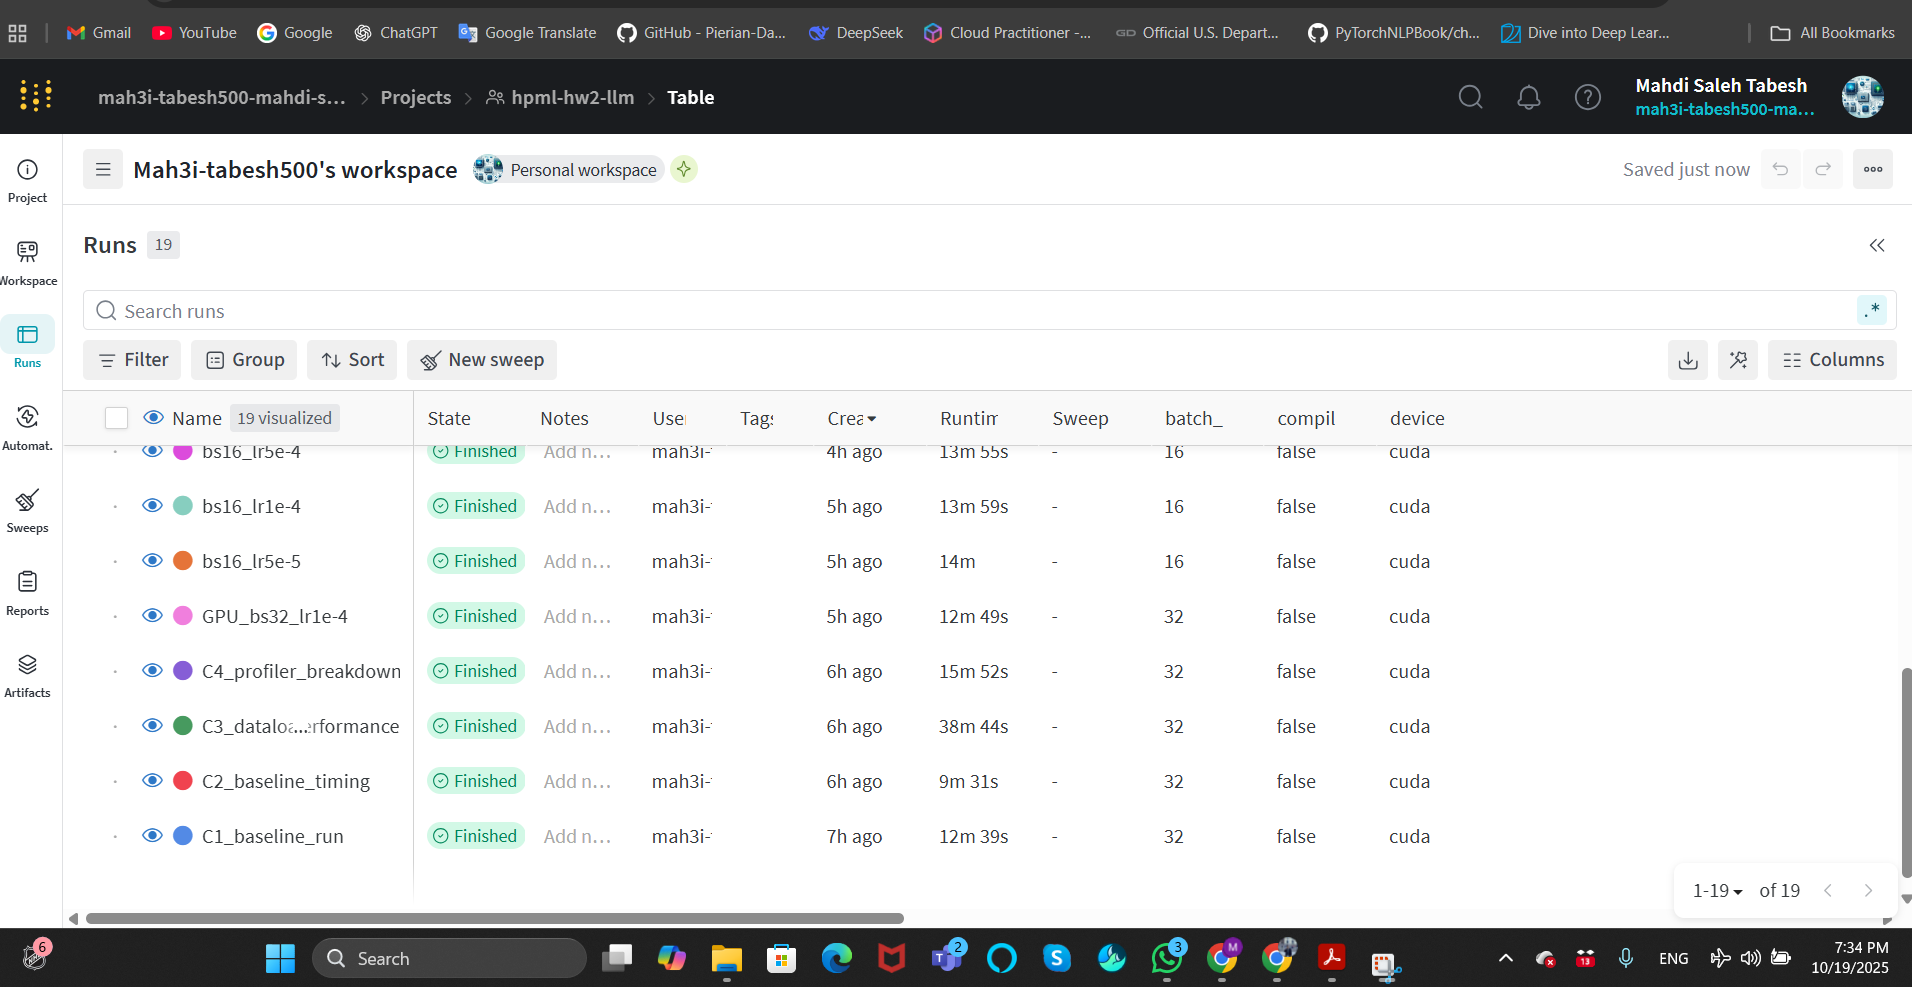

## Figure F1: Training loss and accuracy vs. epoch for DistilBERT fine-tuning on IMDB. The model's loss decreases steadily while accuracy increases, indicating successful learning.

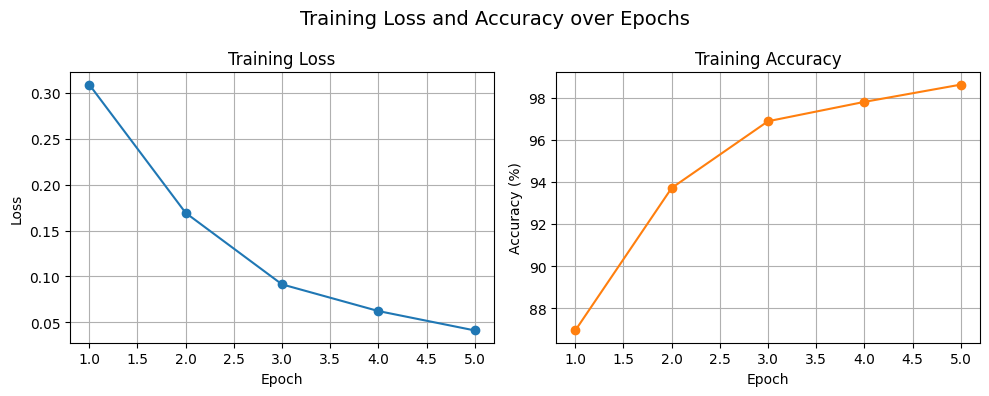

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# Plot training loss
ax1.plot(epochs_range, train_losses, marker='o', color='C0')
ax1.set_title("Training Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)

# Plot training accuracy
ax2.plot(epochs_range, [acc*100 for acc in train_accs], marker='o', color='C1')
ax2.set_title("Training Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.grid(True)

plt.suptitle("Training Loss and Accuracy over Epochs", fontsize=14)
plt.tight_layout()
plt.show()


## Below, Table T1 summarizes the per-epoch training and test metrics:

In [ ]:
# Generate LaTeX table for per-epoch metrics
import pandas as pd

# Create a DataFrame
metrics_df = pd.DataFrame({
    "Epoch": list(range(1, len(train_losses)+1)),
    "Train Loss": [round(x, 4) for x in train_losses],
    "Train Acc": [round(x*100, 2) for x in train_accs],
    "Test Acc": [round(x*100, 2) for x in test_accs]
})

# Display the DataFrame
print(metrics_df)


   Epoch  Train Loss  Train Acc  Test Acc
0      1      0.3090      86.94     89.12
1      2      0.1692      93.71     88.40
2      3      0.0913      96.88     86.94
3      4      0.0623      97.80     87.57
4      5      0.0412      98.62     87.30


## C2: Baseline Timing per Epoch

Task: Next, we profile the training process to understand where time is spent. For each epoch, we measure:

- Data Loading Time: the time spent loading and preparing batches (including tokenization/padding and any waiting for data).

- Compute Time: the time spent on the forward pass, backpropagation, and optimizer step (model computation).

- Total Time: the overall wall-clock time for the epoch (data + compute, accounting for any overlap).

To accurately measure GPU compute time, we use torch.cuda.synchronize() to ensure timing measurements account for completed CUDA operations. We will instrument the training loop to record these timings.

Implementation: We reuse the training loop with added timers. For each epoch, we:

- Start a timer at the beginning of the epoch.

- For each batch, time the data loading (from the end of the previous batch's compute to when the next batch is ready) and the compute step separately.

- Use time.time() or time.perf_counter() to measure elapsed times in seconds. On GPU, we call torch.cuda.synchronize() right after the model computation (forward/backward) before stopping the timer, to ensure all CUDA kernels have finished.

- Accumulate the data loading time and compute time over all batches in the epoch.

- Stop the epoch timer at the end to get total epoch time.

In [ ]:
device

device(type='cuda')

In [ ]:
import time

# Reinitialize model and optimizer for a fresh run (to measure timing from scratch)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Initialize W&B for timing experiment
wandb.init(
    project="hpml-hw2-llm",
    name="C2_baseline_timing",
    group="C2_experiments",
    config={
        "model_name": model_name,
        "batch_size": 32,
        "lr": 1e-4,
        "epochs": 5,
        "optimizer": "AdamW",
        "device": str(device),
        "num_workers": 2,
        "compile_mode": False})

epochs = 5
epoch_data_times = []
epoch_compute_times = []
epoch_total_times = []

for epoch in range(1, epochs+1):
    model.train()
    # Timers for this epoch
    total_start = time.time()
    data_time = 0.0
    compute_time = 0.0

    # Iterate over training batches with timing
    batch_end_time = time.time()  # end time of previous batch's compute (initially, epoch start)
    for batch in train_loader:
        # Measure data loading time: time from end of last compute to now (batch ready)
        data_start_time = time.time()
        data_time += data_start_time - batch_end_time

        # Prepare batch
        batch = {k: v.to(device) for k, v in batch.items()}

        # Compute (forward + backward + optimize) with timing
        compute_start_time = time.time()
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        # If using GPU, synchronize to wait for all operations to finish
        if device.type == "cuda":
            torch.cuda.synchronize()
        compute_end_time = time.time()

        compute_time += compute_end_time - compute_start_time
        batch_end_time = compute_end_time  # update for next batch timing
    total_end = time.time()

    epoch_data_times.append(data_time)
    epoch_compute_times.append(compute_time)
    epoch_total_times.append(total_end - total_start)

    # Log timing for this epoch
    device_used = "GPU" if device.type == "cuda" else "CPU"
    print(f"Epoch {epoch}: Data Time = {data_time:.3f}s, Compute Time = {compute_time:.3f}s, Total Time = {epoch_total_times[-1]:.3f}s ({device_used})")

    # Log to W&B
    wandb.log({
        "time/data": data_time,
        "time/compute": compute_time,
        "time/epoch": epoch_total_times[-1]
    }, step=epoch)

# Finish W&B run
wandb.finish()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1: Data Time = 1.750s, Compute Time = 111.906s, Total Time = 113.917s (GPU)


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 2: Data Time = 1.755s, Compute Time = 111.871s, Total Time = 113.887s (GPU)


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 3: Data Time = 1.770s, Compute Time = 111.867s, Total Time = 113.898s (GPU)


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 4: Data Time = 1.780s, Compute Time = 111.866s, Total Time = 113.919s (GPU)


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 5: Data Time = 1.821s, Compute Time = 111.859s, Total Time = 113.938s (GPU)


time/compute,█▃▂▂▁
time/data,▁▂▃▄█
time/epoch,▅▁▂▅█
time/compute,111.85866
time/data,1.82069
time/epoch,113.93848


# Experiment Tracking (Weights & Biases) link of W&B run page.
- View run C2_baseline_timing at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm/runs/9advd8ar
- View project at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm
- Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
- Find logs at: ./wandb/run-20251019_170744-9advd8ar/logs

# Table T2: Per-epoch timing breakdown

In [ ]:
import pandas as pd

device_used = "GPU" if device.type == "cuda" else "CPU"

# Build DataFrame
t2_df = pd.DataFrame({
    "Epoch": range(1, epochs+1),
    "Data Time (s)": [round(x, 3) for x in epoch_data_times],
    "Compute Time (s)": [round(x, 3) for x in epoch_compute_times],
    "Total (s)": [round(x, 3) for x in epoch_total_times],
    "Device": device_used
})

# Display neatly
print("\nTable T2: Per-Epoch Timing Results\n")
print(t2_df)


Table T2: Per-Epoch Timing Results

   Epoch  Data Time (s)  Compute Time (s)  Total (s) Device
0      1          1.750           111.906    113.917    GPU
1      2          1.755           111.871    113.887    GPU
2      3          1.770           111.867    113.898    GPU
3      4          1.780           111.866    113.919    GPU
4      5          1.821           111.859    113.938    GPU


### Figure F2: Stacked bar chart of data loading time vs. compute time for each epoch. Compute (orange) dominates the total time, while data loading (blue) is a small component in each epoch.

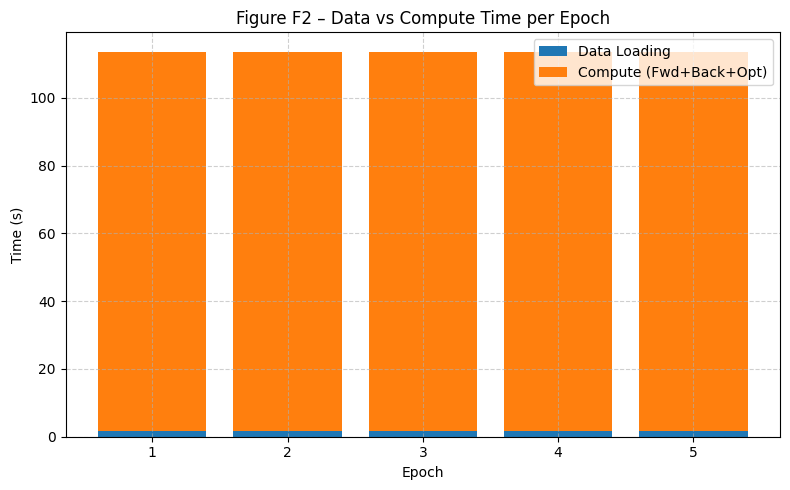

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epochs_range = np.arange(1, epochs+1)

plt.figure(figsize=(8,5))
plt.bar(epochs_range, epoch_data_times, label="Data Loading", color="#1f77b4")
plt.bar(epochs_range, epoch_compute_times, bottom=epoch_data_times,
        label="Compute (Fwd+Back+Opt)", color="#ff7f0e")

plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.title("Figure F2 – Data vs Compute Time per Epoch")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()